# Initial VAE Distribution Testing

In [101]:
#!pip install tensorflow numpy matplotlib pydot graphviz
#!pip install --upgrade h5py

import tensorflow

print(f"TensorFlow Version: {tensorflow.version.VERSION}")

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

TensorFlow Version: 2.0.0


In [102]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [103]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

## Generate Samples from "Arbitrary" Distribution

In [104]:
X1 = np.random.multivariate_normal([0,0], [[0.25,0],[0,0.25]], 5000)
X2 = np.random.multivariate_normal([3,3], [[0.25,0],[0,0.25]], 5000)

X = np.vstack([X1, X2])
np.random.shuffle(X)

min_x = min(X[:,0])
max_x = max(X[:,0])

min_y = min(X[:,1])
max_y = max(X[:,1])

X[:,0] = (X[:,0]-min_x)/(max_x - min_x)
X[:,1] = (X[:,1]-min_y)/(max_y - min_y)

x_train = X[:9000]
x_test  = X[9000:]

input_shape = (2,)

intermediate_dim = 128
batch_size = 128
latent_dim = 2
original_dim = 2

In [105]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='x')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [106]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu', name='out_x')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid', name='output')(x)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
x (Dense)                       (None, 128)          384         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            258         x[0][0]                          
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            258         x[0][0]                          
____________________________________________________________________________________________

## Define Decoder

In [107]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
out_x (Dense)                (None, 128)               384       
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [108]:
models = (encoder, decoder)

MSE = False
WEIGHTS = False

epochs = 50

# VAE loss = mse_loss or xent_loss + kl_loss
if MSE:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.005
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

if WEIGHTS:
    vae.load_model('vae_mlp_mnist.h5')
else:
    # train the autoencoder
    vae.fit(
        x_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=(x_test, None)
    )   

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 900         encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 2)            642         encoder[1][2]                    
__________________________________________________________________________________________________
tf_op_layer_clip_by_value_8/Min [(None, 2)]          0           decoder[1][0]                    
____________________________________________________________________________________________

9000/9000 [==============================] - 0s 25us/sample - loss: 1.1887 - val_loss: 1.1871
Epoch 10/50
9000/9000 [==============================] - 0s 23us/sample - loss: 1.1887 - val_loss: 1.1868
Epoch 11/50
9000/9000 [==============================] - 0s 23us/sample - loss: 1.1883 - val_loss: 1.1864
Epoch 12/50
9000/9000 [==============================] - 0s 24us/sample - loss: 1.1883 - val_loss: 1.1863
Epoch 13/50
9000/9000 [==============================] - 0s 25us/sample - loss: 1.1882 - val_loss: 1.1876
Epoch 14/50
9000/9000 [==============================] - 0s 23us/sample - loss: 1.1883 - val_loss: 1.1868
Epoch 15/50
9000/9000 [==============================] - 0s 23us/sample - loss: 1.1880 - val_loss: 1.1867
Epoch 16/50
9000/9000 [==============================] - 0s 24us/sample - loss: 1.1883 - val_loss: 1.1870
Epoch 17/50
9000/9000 [==============================] - 0s 22us/sample - loss: 1.1881 - val_loss: 1.1859
Epoch 18/50
9000/9000 [==============================] - 0

# Scatter Plot of Original Data

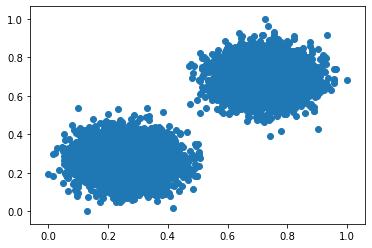

In [113]:
fig_0 = plt.scatter(X[:,0], X[:,1])

## Sampling From the Model

We'll first generate multivariate data from NumPy and send this through the decoder to determine how well the decoder replicates the original distribution. 

In [109]:
X_Test = np.random.multivariate_normal([0,0], [[1,0],[0,1]], 1000)

results = decoder.predict(X_Test)

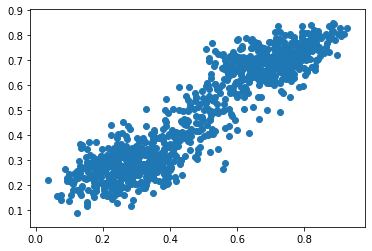

In [110]:
plt.scatter(results[:,0], results[:,1])

This leaves a lot to be desired, we see that it _kind of_ looks like our original distribution (if we're being generous)

# Stored Latent Representations

Let's now look at the stored latent representations of the `x_test` dataset

In [111]:
encoded = encoder.predict(x_test)[0]
print(encoded)

[[ 0.987072    1.0586257 ]
 [ 0.5454304   0.4536318 ]
 [ 1.3297424   1.4983327 ]
 ...
 [-1.6697013  -0.38763562]
 [-0.5864523  -0.45113537]
 [ 0.61729014 -1.8954529 ]]


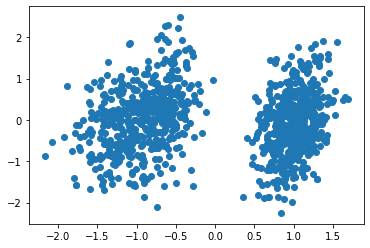

In [112]:
fig = plt.scatter(encoded[:,0], encoded[:,1])

Not surprisingly they are stored as two separate clusters within the encodings, and we start to get an idea of why our decoder is behaving poorly, the two non-dense clusters leave gaps in the encodings that does represent data that needs to be replicated and as such when we pull from this source, it give data that doesn't fit the original distribution well.

# Pass Through the Model

We now want to see how the pass through the model looks like.

In [114]:
en_de = decoder.predict(encoded)

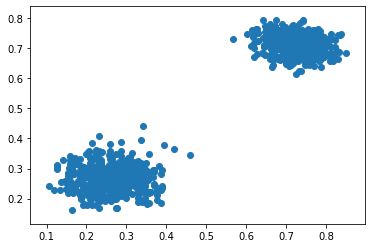

In [115]:
plt.scatter(en_de[:,0], en_de[:,1])

In [116]:
through = vae.predict(x_test)

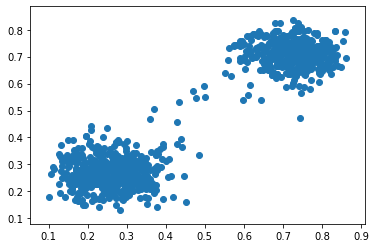

In [117]:
plt.scatter(through[:,0], through[:,1])

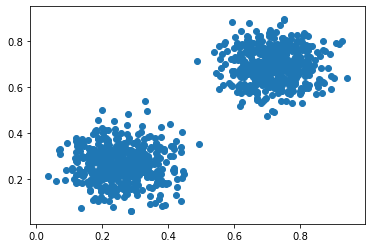

In [119]:
plt.scatter(x_test[:,0], x_test[:,1])

# Notes

1. We can improve the "denseness" of the internal representation by modifying the constant multiplier in the `KL Loss` Function

1. It may work better if there is uniform noise throughout the entire distribution (that's my next check)